## 자전거 수요 예측
#### 앙상블 회귀 추가

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북 안에 그래프 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제 해결 방법
mpl.rcParams['axes.unicode_minus'] = False

- 파일 경로(로컬과 웹에서 다르므로)

In [2]:
train_path = "train.csv"
test_path = "test.csv"
submission_path =  ' '

In [3]:
train = pd.read_csv(train_path, parse_dates=['datetime'])
# train.shape
print( train.shape,'\n')
train.head()

(10886, 12) 



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test= pd.read_csv(test_path, parse_dates=['datetime'])
print(test.shape)
test.head()


(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


DataFrame에 시간 데이터 전부를 담지 않고,  
사용할 data features만 담기

In [5]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
print(train.shape)
train.head()

(10886, 16)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


In [6]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
print(test.shape)
test.head()


(6493, 13)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,hour,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,4,3


In [7]:
print(train['season'].unique())

[1 2 3 4]


In [8]:
# 연속형 feature와 범주형 feature로 

categorical_feature_names = ["season",'holiday','workingday','weather',
                             'dayofweek','month','year','hour']

In [9]:
# 범주형 feature의 type을 category로 변경한다.
for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")    

In [10]:
feature_names =["season",'weather','temp','atemp','humidity','year','hour',
                             'dayofweek','holiday','workingday']

feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [11]:
X_train = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [12]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [13]:
label_name = 'count'

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

# 평가식
- 평가 방법을 rmsle 사용하므로  평가 방법에 맞게 함수 통해 점수 계산하기



from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp = True):
    
    if convertExp :
        # exp : exponential로 자연 상수e를 의미합니다!
        predicted_valeus = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # numpy 배열 형태로 바꾸기
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제값에 1을 더하고 로그를 씌우기
    log_predict = np.log(predicted_values +1)
    log_actual = np.log(actual_values +1)
    
    #위에서 계산한 예측값에서 실제값을 빼주고 제곱하기.
    
    difference = log_predict- log_actual
    difference = np.square(difference)
    
    # 평균 구하기
    mean_difference = difference.mean()
    
    # 다시 루트 씌우기
    
    score = np.sqrt(mean_difference)
    
    return score

In [14]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):

    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
        
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score


# 선형회귀 모델 Linear Regression Model

    - 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘 입니다.
    - 선형회귀는 예측과 훈련 세트에 있는 타깃 y아이의 평균제곱오차(Mean Squre Error : MSE)를 최소화하는 
      파라미터 w와 b를 찾습니다.
    - 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있습니다.
   

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category = DeprecationWarning)

# 선형회귀 모델 초기화
lModel = LinearRegression()

# 모델 학습
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

# 예측하고 정확도 평가
predicts = lModel.predict(X_train)
print('RMSLE Value For Linear Regression: ', 
     rmsle(np.exp(y_train_log), np.exp(predicts),False))

RMSLE Value For Linear Regression:  0.9803697923313522


# 릿지(Regularization Model - Ridge)
    - 회귀를 위한 선형모델
    - 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
    - Regularization(규제)는 오버비팅(과적합)이 되지 않도록 모델을 강제로 제한한다는 의미입니다.
    - max_iter(반복 실행하는 최대 횟수)는 3000을 주었습니다.

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780791


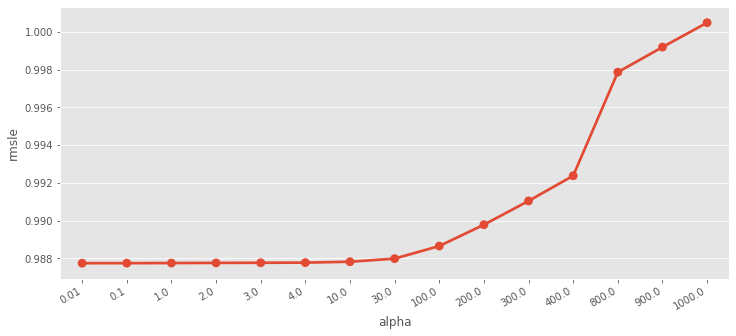

In [16]:
e_m_ = Ridge()

e_params_ = {'max_iter':[3000], 'alpha':[0.01, 0.1, 1,2,3,4,10,30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_ridge_m = GridSearchCV( e_m_,
                             e_params_ ,
                              scoring = rmsle_scorer, 
                              cv = 5 )

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log)
preds = grid_ridge_m.predict(X_train)

print(grid_ridge_m.best_params_)
print('RMSLE Value For Ridge Regression: ', 
     rmsle(np.exp(y_train_log), np.exp(preds),False))


fig,ax = plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df['params'].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)


# 라쏘 Regularization Model - Lasso
    * 선형회귀의 Regularization(규제)를 적용하는 대안
    * 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 한다. 
       어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
    * 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
    * alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
    * 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025이다.
    * max_iter(반복 실행하는 최대 횟수)는 3000이다.
    

In [17]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m.fit( X_train , y_train_log )
preds = grid_lasso_m.predict(X_train)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(y_train_log),np.exp(preds),False))

df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

{'alpha': 0.00125, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9803727821457655


,alpha,rmsle
0,10.000000,1.397124
1,1.000000,1.071947
2,0.500000,1.062110
3,0.333333,1.060815
4,0.250000,1.061139


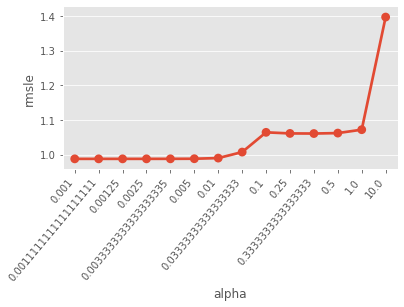

In [18]:

fig,ax= plt.subplots()
fig.set_size_inches(6,3)
plt.xticks(rotation=50, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)


# 앙상블모델 - 랜덤포레스트

## Ensemble Models - Random Forest


In [19]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Random Forest: ",score)



RMSLE Value For Random Forest:  0.1071141043402517


# 앙상블모델 - 그라디언트 부스트

## Ensemble Model - Gradient Boost

* 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있음
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
* 무작위성이 없고 강력한 사전 가지치기가 사용 됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
* learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
* max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.


In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print ("RMSLE Value For Gradient Boost: ", score)


RMSLE Value For Gradient Boost:  0.2135740372724937


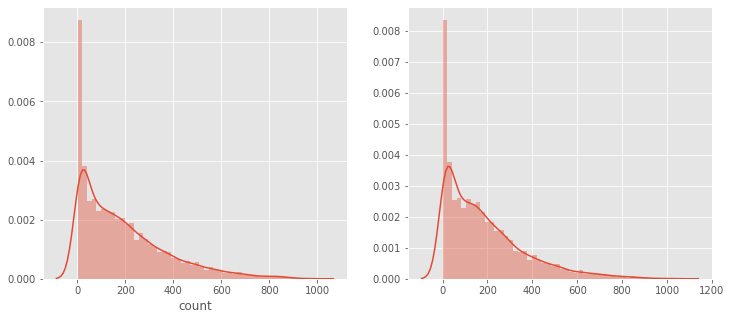

In [21]:

predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

# Submit

In [22]:
submission = pd.read_csv("./sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.227543
1,2011-01-20 01:00:00,6.296610
2,2011-01-20 02:00:00,4.259238
3,2011-01-20 03:00:00,2.666615
4,2011-01-20 04:00:00,2.295918
